# **Name:** YANG Yongze, DUAN Suyang

**EIDs:** 58162210(YANG Yongze), 58490066(DUAN Suyang)

**Kaggle Competition:** LLM - Detect AI Generated Text

**Kaggle Team Name:** Yongze & Suyang


# CS5489 - Course Project (2023A)


# Course Project - LLM - Detect AI Generated Text

Course Project for CS5489(2023/2024A).

The members of our Group (Group 56) are as follows:

| Name        | EID       | Contribution |
| ----------- | --------- | ------------ |
| YANG Yongze | 5816 2280 | 50%          |
| Duan Suyang | 5849 0066 | 50%          |

## Introduction

This project comes from a public Kaggle competition. For this competition, participants were asked to implement a classifier to determine whether an essay was completed by the student or generated by LLMs, which is recognized as plagiarism and academic misconduct. This classifier is a 0-1 binary classifier for text processing. 

![Introduction](imgs/introduction.png)
**Fig 1** - Introduction of our classifier

## Overview of Our Work

Our work in this project can be represented by the following flowchart:

![overview](imgs/overview.png)
**Fig 2** - Overview of our work


In the original Kaggle competition, no actual training and testing data sets were given. In the discussion forum of this Kaggle competition, we found the LLM datasets organized by a user, Luciano Batista [2], and we used them as a dataset source. We first acquired the dataset. We then did some preprocessing, such as removing repetitions, converting to word lists(for the purpose of the Word2Vec representation later), etc.

We have tried a variety of ways to convert these text into different feature represention forms. We tried N-Gram, TF-IDF, Word2Vec, and some combinations of them, and tried dimensionality reduction in feature representations with higher dimensionality. We recorded these different features respectively.

After that, we used a variety of machine learning methods, including SVMs with multiple kernels, random forests, and neural networks, etc., and tuned the parameters by means of Grid Search, N Fold Cross Validation, then we trained and predicted with these classifiers.

We used AUROC(Area Under Receiver Operating Characteristic Curve) as the main rubric, which is the same basis for Kaggle rankings. We also used metrics such as Accuracy, F1 Score, and Precision to get a more comprehensive picture of the performance of these classifiers.

Below will be all our attempts in this Project, including code and documents.

## Dataset Spliting

First, we need to import all the dependencies.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
random.seed(100)
import pandas as pd
import numpy as np

from joblib import dump, load
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
from scipy import stats
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import xgboost as xgb
from tqdm import tqdm

from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score

Let's take a look at the raw data distribution. In this Kaggle competition, the organizers did not provide the original dataset, only a simple example. 

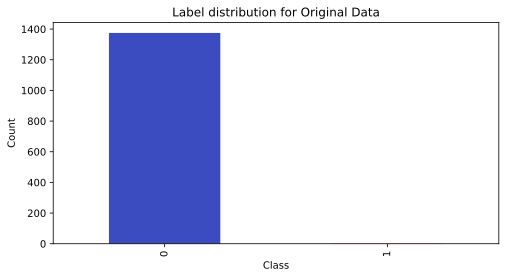

In [ ]:
df_o = pd.read_csv('llm-detect-ai-generated-text/train_essays.csv')
plt.figure(figsize=(8, 4))
df_o.generated.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Label distribution for Original Data")
plt.show()

Here, the data has only negative samples and no positive samples. This means we must need to find our own dataset to train and test. 

For the dataset we found ourselves [2], it contains positive samples in its distribution. But here the positive and negative sample data are not balanced, there is a difference in the number between them, although this difference is not very large.

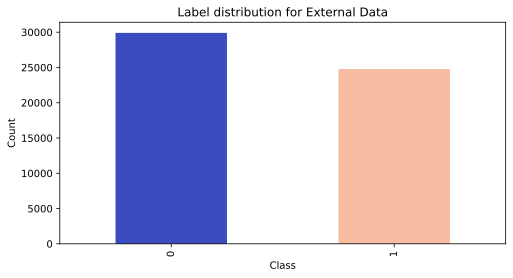

In [ ]:
df = pd.read_csv('concatenated.csv')
plt.figure(figsize=(8, 4))
df.generated.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Label distribution for External Data")
plt.show()

We divided the data into a training set and a test set with a ratio of 80-20.

In [ ]:
df_class_0 = df[df['generated'] == 0]
df_class_1 = df[df['generated'] == 1]

train_0, test_0 = train_test_split(df_class_0, test_size=0.2, random_state=42)
train_1, test_1 = train_test_split(df_class_1, test_size=0.2, random_state=42)

df_train = pd.concat([train_0, train_1]).sample(frac=1).reset_index(drop=True)
df_test = pd.concat([test_0, test_1]).sample(frac=1).reset_index(drop=True)


Let's look at the specific data distributions in the training and test sets.

In [ ]:
df_train.generated.value_counts()

0    23925
1    19827
Name: generated, dtype: int64

In [ ]:
df_test.generated.value_counts()

0    5982
1    4957
Name: generated, dtype: int64

After that, we save the training set and the test set separately as csv files after splitting.

In [ ]:
df_train.to_csv('train_essays.csv', index=False)
df_test.to_csv('test_essays.csv', index=False)

We need to load the dataset for our project. In this csv dataset, the "text" column is the essay itself, and generated indicates whether the essay was generated by LLM.

In Kaggle, the test_essay.csv dataset is replaced with the actual dataset used for testing. We can replace train_essay.csv with the full dataset.

In [ ]:
train_csv_path = 'kaggle/input/llm-detect-ai-generated-text/train_essays.csv'
test_csv_path = 'kaggle/input/llm-detect-ai-generated-text/test_essays.csv'

train_dataset_df = pd.read_csv(train_csv_path)
test_dataset_df = pd.read_csv(test_csv_path)

train_text_list = train_dataset_df['text'].tolist()
test_text_list = test_dataset_df['text'].tolist()

train_y = train_dataset_df['generated'].values
test_y = test_dataset_df['generated'].values

train_id = train_dataset_df['id'].tolist()
test_id = test_dataset_df['id'].tolist()

## Feature Representation

### Using N-Gram & Tf-IDF

First, we can use n-gram to obtain the feature representation in the text. We did not take BoW to represent the text data, although BoW is simple and efficient, it only focuses on the presence or absence of words.N-Gram can accurately capture the relationship of neighboring words, which can better reflect the information of the context and generate better features. For LLM generated articles, it may contain important information in the context before and after, so N-Gram is a better representation.

We also use TF-IDF to further measure the contextual information and importance weights between texts. In this way, each n-gram term can be involved in the feature representation in a more fine-grained way, which can better distinguish the differences between different texts.

In [ ]:
# Bag of Words with N-Gram
vectorizer_ngram = CountVectorizer(ngram_range=(1, 2),max_features=10000)
train_ngram = vectorizer_ngram.fit_transform(train_text_list)
test_ngram = vectorizer_ngram.transform(test_text_list)
set_ngram = [train_ngram, test_ngram]
print("[N-Gram] train dataset shape: ", shape(train_ngram))
print("[N-Gram] test dataset shape: ", shape(test_ngram))

# Tf-Idf 
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_TfIdf = tf_trans.fit_transform(train_ngram)
test_TfIdf = tf_trans.transform(test_ngram)
set_TfIdf = [train_TfIdf, test_TfIdf]
print("[TF-IDF] train dataset shape: ", shape(train_TfIdf))
print("[TF-IDF] test dataset shape: ", shape(test_TfIdf))


[N-Gram] train dataset shape:  (43752, 10000)
[N-Gram] test dataset shape:  (10939, 10000)
[TF-IDF] train dataset shape:  (43752, 10000)
[TF-IDF] test dataset shape:  (10939, 10000)


### Dimensionality reduction

In the feature representation of N-Gram and TF-IDF, we retain the number of 10,000 features by default, which means that only words or phrases ranked in the top 10,000 are considered. But this is a very large number, so we need to reduce this dimension and keep the main components. Hence, we need to reduce the dimension.

We will pick both TruncatedSVD and PCA for dimensionality reduction. In order to get a suitable number of components, we set different n_components parameters and implement multiple dimensionality reduction. After each dimensionality reduction, we implemented a simple Bernoulli Naive Bayes classifier, trained and predicted with the dimensionality reduced data to obtain the final AUC value to get a more appropriate n_components parameter.

First, we use TruncatedSVD.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

for n_components in [250,500,750,1000,1250,1500,1575,1750,2000,2250,2500,2750,3000,3150]:
    print(n_components)
    svd = TruncatedSVD(n_components)
    train_svd = svd.fit_transform(train_TfIdf)
    test_svd = svd.transform(test_TfIdf)
    
    bnb = BernoulliNB()
    bnb.fit(train_svd, train_y)
    y_pred = bnb.predict(test_svd)
    auc = roc_auc_score(test_y, y_pred)
    print(f"n_components: {n_components}, AUC: {auc}")

250
n_components: 250, AUC: 0.8881634480470529
500
n_components: 500, AUC: 0.88935940698162
750
n_components: 750, AUC: 0.8933654908643622
1000
n_components: 1000, AUC: 0.8938352614160145
1250
n_components: 1250, AUC: 0.8947920858938865
1500
n_components: 1500, AUC: 0.8944231828023914
1575
n_components: 1575, AUC: 0.8952445730709714
1750
n_components: 1750, AUC: 0.8957316269971909
2000
n_components: 2000, AUC: 0.894307864754913
2250
n_components: 2250, AUC: 0.8943597148786148
2500
n_components: 2500, AUC: 0.8960141132158495
2750
n_components: 2750, AUC: 0.8947085018082963
3000
n_components: 3000, AUC: 0.8948122020556997
3150
n_components: 3150, AUC: 0.8946249177227062


Then, we tried PCA.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

for n_components in [250,500,750,1000,1250,1500,1575,1750,2000,2250,2500,2750,3000,3150]:
    svd = TruncatedSVD(n_components)
    train_svd = svd.fit_transform(train_TfIdf)
    test_svd = svd.transform(test_TfIdf)
    
    bnb = BernoulliNB()
    bnb.fit(train_svd, train_y)
    y_pred = bnb.predict(test_svd)
    auc = roc_auc_score(test_y, y_pred)
    print(f"n_components: {n_components}, AUC: {auc}")

n_components: 250, AUC: 0.9021962161111806
n_components: 500, AUC: 0.9084386674919521
n_components: 750, AUC: 0.9107356701265117
n_components: 1000, AUC: 0.9113898922239112
n_components: 1250, AUC: 0.9143728509177589
n_components: 1500, AUC: 0.9158597944327231
n_components: 1575, AUC: 0.9164766169937423
n_components: 1750, AUC: 0.9171971398021648
n_components: 2000, AUC: 0.9182202649910596
n_components: 2250, AUC: 0.9199551279755479
n_components: 2500, AUC: 0.9191972056307447
n_components: 2750, AUC: 0.9186900355427118
n_components: 3000, AUC: 0.9208975018660986
n_components: 3150, AUC: 0.9237305757633332


It is clear that the accuracy obtained using PCA is higher than TruncatedSVD and that the optimal n_components is 2750.

We believe that our raw data may have had a stronger linear structure and more pronounced variance in some of the principal components, and that PCA may have captured these features better, resulting in higher AUC values.

Although the parameter we obtained may be affected by the Bernoulli Naive Bayes classifier, we believe this parameter is acceptable.

Therefore, we can use PCA to reduce the feature dimension to 2750 in subsequent experiments.

In [ ]:
train_TfIdf_array = train_TfIdf.toarray()
test_TfIdf_array = test_TfIdf.toarray()
from sklearn.decomposition import PCA

pca = PCA(2750)
train_TfIdf_pca = pca.fit_transform(train_TfIdf_array)
test_TfIdf_pca = pca.transform(test_TfIdf_array)
set_TfIdf_pca = [train_TfIdf_pca, test_TfIdf_pca]

pca = PCA(2750)
train_ngram_pca = pca.fit_transform(train_ngram.toarray())
test_ngram_pca = pca.transform(test_ngram.toarray())
set_ngram_pca = [train_ngram_pca, test_ngram_pca]

print("[N-Gram, PCA] train dataset shape: ", shape(train_ngram_pca))
print("[N-Gram, PCA] test dataset shape: ", shape(test_ngram_pca))
print("[TF-IDF, PCA] train dataset shape: ", shape(train_TfIdf_pca))
print("[TF-IDF, PCA] test dataset shape: ", shape(test_TfIdf_pca))

[N-Gram, PCA] train dataset shape:  (43752, 2750)
[N-Gram, PCA] test dataset shape:  (10939, 2750)
[TF-IDF, PCA] train dataset shape:  (43752, 2750)
[TF-IDF, PCA] test dataset shape:  (10939, 2750)


### Using Word2Vec

**Word2Vec** \[3\] may be a good choice for word embedding. For Word2Vec, it captures the semantic relationships between words, takes into account the contextual relationships of words, and can map a high-dimensional discrete lexical space to a low-dimensional continuous vector space.

We need to do some preprocessing first when we do this step. In the original text, each piece of data is a string, and we need to convert this essay string into a LIST composed of words.

In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize, PorterStemmer, SnowballStemmer, WordNetLemmatizer
import re
import nltk

# Init stop words and stemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_list(str):
    """
    Preprocess text data by removing non-alphanumeric characters & stop word and lemmatizing

    :param str: input string
    :return: preprocessed word list
    """

    # Remove non-alphanumeric characters
    string_only_alphanumeric = re.sub(r'[^a-zA-Z0-9]', ' ', str)
    # Tokenize the string into individual words
    words = word_tokenize(string_only_alphanumeric)
    new_str = []

    for word in words:
        if not word.isdigit():
            # lemmatization and convert to lower case
            stemmed_word = lemmatizer.lemmatize(word)
            lower_word = stemmed_word.lower()
            new_str.append(lower_word)
    return new_str

test = 'En chikku nange bakra msg kalstiya..then had tea/coffee?'
print(preprocess_list(test))

train_word_list = [preprocess_list(s) for s in train_text_list]
test_word_list = [preprocess_list(s) for s in test_text_list]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['en', 'chikku', 'nange', 'bakra', 'msg', 'kalstiya', 'tea', 'coffee']


We still need to find the optimal parameters. Here we have used Grid Search to find the best parameters. We still use Bernoulli Naive Bayes as a classifier as we did before, training and predicting separately to get the AUC value as a reference.

In [ ]:
from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score

param_grid = {
    'vector_size': [50, 75, 100, 125, 150, 200, 500],
    'window': [2, 3, 4, 5, 7, 10],
    'min_count': [1, 2, 3]
}
best_score = 0
best_params = None

model_bnb_w2v = naive_bayes.BernoulliNB(alpha=1e-10)

# Grid Search for Parameters
for params in ParameterGrid(param_grid):
    model_w2v = Word2Vec(train_word_list, **params)
    X = []
    # Build word2Vec features
    for sentence in train_word_list:
        sentence_vector = []
        for word in sentence:
            # if the word is in the wv list
            if word in model_w2v.wv:
                word_vec = model_w2v.wv[word]
                sentence_vector.append(word_vec)
        if len(sentence_vector) > 0:
            # can be presented as a vector
            average_vec = np.mean(sentence_vector,axis=0)
        else:
            # vector of 0 as default
            average_vec = np.zeros(params['vector_size'])
        X.append(average_vec)

    # Split data
    X_train, X_valid, ytrain, yvalid = train_test_split(X, train_y, stratify=train_y, test_size=0.7, random_state=0)

    # USe bnb to train and predict
    model_bnb_w2v.fit(X_train,ytrain)
    y_pred = model_bnb_w2v.predict(X_valid)

    auc = roc_auc_score(yvalid, y_pred)

    print('params: ', params, 'auc: ', auc)

    # Get the best balanced accuracy score
    if auc > best_score:
        best_score = auc
        best_params = params

print(f'Best auc score: {best_score}')
print(f'Best params: {best_params}')

params:  {'min_count': 1, 'vector_size': 50, 'window': 2} auc:  0.8445789947400147
params:  {'min_count': 1, 'vector_size': 50, 'window': 3} auc:  0.8419238857281267
params:  {'min_count': 1, 'vector_size': 50, 'window': 4} auc:  0.8638585886944722
params:  {'min_count': 1, 'vector_size': 50, 'window': 5} auc:  0.8588277471793984
params:  {'min_count': 1, 'vector_size': 50, 'window': 7} auc:  0.8702190834799028
params:  {'min_count': 1, 'vector_size': 50, 'window': 10} auc:  0.8784571810772648
params:  {'min_count': 1, 'vector_size': 75, 'window': 2} auc:  0.828778601686168
params:  {'min_count': 1, 'vector_size': 75, 'window': 3} auc:  0.8564685983556697
params:  {'min_count': 1, 'vector_size': 75, 'window': 4} auc:  0.8636363261025738
params:  {'min_count': 1, 'vector_size': 75, 'window': 5} auc:  0.8602602743119494
params:  {'min_count': 1, 'vector_size': 75, 'window': 7} auc:  0.8562834254037197
params:  {'min_count': 1, 'vector_size': 75, 'window': 10} auc:  0.8768142958198119
par

The best parameter sets are {'min_count': 1, 'vector_size': 500, 'window': 10}. Then we used Word2Vec with these parameters to embed word into vectors.

In [ ]:
from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score

model_w2v = Word2Vec(train_word_list, min_count= 1, vector_size= 500, window= 10)

def generate_w2v(word_list):
    X = []
    # Build word2Vec features
    for sentence in word_list:
        sentence_vector = []
        for word in sentence:
            # if the word is in the wv list
            if word in model_w2v.wv:
                word_vec = model_w2v.wv[word]
                sentence_vector.append(word_vec)
        if len(sentence_vector) > 0:
            # can be presented as a vector
            average_vec = np.mean(sentence_vector,axis=0)
        else:
            # vector of 0 as default
            average_vec = np.zeros(500)
        X.append(average_vec)
    return X

train_w2v = generate_w2v(train_word_list)
test_w2v = generate_w2v(test_word_list)
set_w2v = [train_w2v, test_w2v]

print(shape(train_w2v))
print(shape(test_w2v))

(43752, 500)
(10939, 500)


## Grid Search for Different Classifiers

After obtaining the feature representation, we can start experimenting with different classifiers for training, prediction and evaluation. For traditional machine learning methods, we still need to use Grid Search to find the best parameters.

Here, we treat the features as a set. We look for the set of parameters that makes the auc of each kind of features maximal.

In [ ]:
feature_sets_pcas_w2v = {
    'TfIdf_pca' : [train_TfIdf_pca,test_TfIdf_pca],
    'ngram_pca': [train_ngram_pca, test_ngram_pca],
    'w2v': [train_w2v, test_w2v]
}

Here, we firstlt still use Naive Bayes as an example to find a suitable parameter.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import naive_bayes


parameters = {'alpha': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

for name, dataset in feature_sets_pcas_w2v.items():

    print("Feature: ", name)

    nb = naive_bayes.BernoulliNB()

    clf = GridSearchCV(nb, parameters, cv=5, scoring='roc_auc')

    clf.fit(dataset[0], train_y)

    print("     Best parameters set found on development set:")
    print(clf.best_params_)

    y_true, y_pred = test_y, clf.predict(dataset[1])

    print("     Best AUC Score: ", roc_auc_score(y_true, y_pred))

Feature:  TfIdf_pca
     Best parameters set found on development set:
{'alpha': 1e-10}
     Best AUC Score:  0.9122364909266162
Feature:  ngram_pca
     Best parameters set found on development set:
{'alpha': 1}
     Best AUC Score:  0.8617024329663053
Feature:  w2v
     Best parameters set found on development set:
{'alpha': 100}
     Best AUC Score:  0.874754854301321


For different types of feature representations, we have searched for a suitable parameter that maximizes the AUC. For grid search, we used 5 fold cross-validation, where the model is trained 5 times, each time with a different subset of data as the validation set and the rest as the training set, to avoid overfitting of the data.

Next, we used a variety of machine learning methods including Support Vector Machines (with different kernels), Ada Boost Classifier, XGBoost Classifier, Random Forest, Gradient Boosting Classifier, Gradient Boosting Classifier, K Nearest Neighbors Classifier, and different parameter ranges for them. We present these classifiers and their corresponding clf in a dictionary.

In [ ]:
# setup all the parameters and models
exps = {
    'svm-lin': { 
        'paramgrid': {'C': logspace(-2,3,5)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,5), 
                      'gamma': logspace(-4,3,5) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,5), 
                      'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },   
    'ada': {
        'paramgrid': {'learning_rate': logspace(-6,0,5), 
                      'n_estimators': [5, 15, 25, 50, 100, 200, 500, 1000]},
        'clf': ensemble.AdaBoostClassifier(random_state=4487) },
    'xgb': {
        'paramsampler': {    
            "gamma":            stats.uniform(0, 0.5),    # default=0
            "max_depth":        stats.randint(2, 6),      # default=6
            "subsample":        stats.uniform(0.6, 0.4),  # default=1
            "learning_rate":    stats.uniform(.001,1),    # default=1 (could also use loguniform)
            "n_estimators":     stats.randint(10, 1000),
         },
        'clf': xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', 
                                 random_state=4487, use_label_encoder=False) },
    'rf': {
        'paramsampler':  {'max_features':      stats.uniform(0,0.5),
                          'max_depth':         stats.randint(1,10),
                          'n_estimators':      [5, 15, 25, 50, 100,200,500,1000]},
        'clf': ensemble.RandomForestClassifier(random_state=4487) },
    'gb': {
        'paramsampler':  {'learning_rate': logspace(-6,0,5),
                          'n_estimators':      [5, 15, 25, 50, 100,200,500,1000]},
        'clf': ensemble.GradientBoostingClassifier()
          },
    'knn': {
        'paramsampler':  { 'n_neighbors': [2, 3, 4, 5, 7,10]},
           'clf': neighbors.KNeighborsClassifier()
    }
}


Below is the function we have defined that will traverse these classifiers to generate the combination of parameters that maximizes the AUC value based on the given feature representation.

In [ ]:
def test_different_model(trainXfn, trainY, testXfn, testY, dataset_name, exps):
    aucs = {}
    clfs2 = {}
    for (name,ex) in exps.items():
        print("=== " + name + " ===")
        if name in clfs2:
            print("exists skipping")
        else:        
            if 'paramgrid' in ex:
                myclf = model_selection.GridSearchCV(ex['clf'], ex['paramgrid'], cv=5, verbose=0, n_jobs=4)
            else:
                myclf = model_selection.RandomizedSearchCV(ex['clf'], 
                                param_distributions=ex['paramsampler'], 
                                random_state=4487, n_iter=100, cv=5, 
                                verbose=0, n_jobs=4)

            myclf.fit(trainXfn, trainY)

            print("best params:", myclf.best_params_)

            clfs2[name] = myclf
    predYtrain = {}
    predYtest  = {}
    for (name,clf) in tqdm(clfs2.items()):
        predYtrain[name] = clf.predict(trainXfn)
        predYtest[name]  = clf.predict(testXfn)
        dump(clf, dataset_name + name+'.joblib')

        # calculate accuracy
        # trainacc = metrics.accuracy_score(trainY, predYtrain[name])
        # testacc  = metrics.accuracy_score(testY, predYtest[name])
        auc = roc_auc_score(testY, predYtest[name])
        # trainaccs[name] = trainacc
        # testaccs[name] = testacc
        aucs[name] = auc
        print("{}: AUC={}".format(name, auc))
        
    return(name, aucs)

Next, we ran the above code and found these parameter combinations. Notably, we found an anomaly in that almost all of the classifiers had AUC values close to 1. This is a very unusual phenomenon and it is likely that overfitting has occurred.

In [ ]:
for (dataset_name, data) in accuracy_result.items():
    print('-----------Feature: ', dataset_name,'------------')
    # if data["scores"] is None:
    model_name, aucs = test_different_model(
        data["train_data"][::50], 
        train_y[::50], 
        data["test_data"][::50], 
        test_y[::50], 
        dataset_name,
        exps)
    accuracy_result[dataset_name]["scores"].update(aucs)

-----------Feature:  ngram_pca ------------
=== svm-lin ===
best params: {'C': 0.01}
=== svm-rbf ===
best params: {'C': 56.23413251903491, 'gamma': 0.0001}
=== svm-poly ===
best params: {'C': 56.23413251903491, 'degree': 3}
=== ada ===
best params: {'learning_rate': 0.03162277660168379, 'n_estimators': 200}
=== xgb ===


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best params: {'gamma': 0.47730797590390733, 'learning_rate': 0.03128787251158516, 'max_depth': 3, 'n_estimators': 131, 'subsample': 0.917426255512291}
=== rf ===
best params: {'max_depth': 6, 'max_features': 0.43451987102243345, 'n_estimators': 500}
=== gb ===


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best params: {'n_estimators': 100, 'learning_rate': 0.03162277660168379}
=== knn ===


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best params: {'n_neighbors': 4}


 25%|██▌       | 2/8 [00:00<00:00, 11.35it/s]

svm-lin: AUC=1.0
svm-rbf: AUC=1.0
svm-poly: AUC=1.0


 75%|███████▌  | 6/8 [00:01<00:00,  5.61it/s]

ada: AUC=0.9563131313131312
xgb: AUC=1.0
rf: AUC=1.0
gb: AUC=1.0


100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


knn: AUC=0.8781565656565657
-----------Feature:  TfIdf_pca ------------
=== svm-lin ===
best params: {'C': 1000.0}
=== svm-rbf ===
best params: {'C': 1000.0, 'gamma': 0.31622776601683794}
=== svm-poly ===
best params: {'C': 3.1622776601683795, 'degree': 2}
=== ada ===
best params: {'learning_rate': 1.0, 'n_estimators': 1000}
=== xgb ===
best params: {'gamma': 0.16311870831311914, 'learning_rate': 0.6119230096208286, 'max_depth': 4, 'n_estimators': 156, 'subsample': 0.9755043267800043}
=== rf ===
best params: {'max_depth': 9, 'max_features': 0.09309595656228176, 'n_estimators': 200}
=== gb ===


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best params: {'n_estimators': 1000, 'learning_rate': 1.0}
=== knn ===
best params: {'n_neighbors': 2}


 25%|██▌       | 2/8 [00:00<00:00,  8.76it/s]

svm-lin: AUC=1.0
svm-rbf: AUC=1.0


 38%|███▊      | 3/8 [00:00<00:00,  8.46it/s]

svm-poly: AUC=1.0


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

ada: AUC=1.0
xgb: AUC=1.0
rf: AUC=1.0
gb: AUC=1.0
knn: AUC=0.797979797979798
-----------Feature:  w2v ------------
=== svm-lin ===
best params: {'C': 0.01}
=== svm-rbf ===


best params: {'C': 1000.0, 'gamma': 0.0001}
=== svm-poly ===
best params: {'C': 3.1622776601683795, 'degree': 2}
=== ada ===
best params: {'learning_rate': 0.03162277660168379, 'n_estimators': 500}
=== xgb ===
best params: {'gamma': 0.4257366859173304, 'learning_rate': 0.35526774997253563, 'max_depth': 4, 'n_estimators': 734, 'subsample': 0.6262634075987297}
=== rf ===
best params: {'max_depth': 8, 'max_features': 0.14000883833708455, 'n_estimators': 1000}
=== gb ===


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best params: {'n_estimators': 100, 'learning_rate': 1.0}
=== knn ===
best params: {'n_neighbors': 3}


  0%|          | 0/8 [00:00<?, ?it/s]

svm-lin: AUC=0.9470959595959595
svm-rbf: AUC=0.9765151515151516
svm-poly: AUC=0.9857323232323233


 50%|█████     | 4/8 [00:00<00:00, 26.42it/s]

ada: AUC=1.0
xgb: AUC=1.0


 88%|████████▊ | 7/8 [00:00<00:00, 18.95it/s]

rf: AUC=1.0
gb: AUC=1.0


100%|██████████| 8/8 [00:00<00:00, 21.38it/s]

knn: AUC=0.9655303030303031


## Train the classifier using the optimal parameter set

Next, we used the previously obtained set of parameters to train our classifier. 

For the Kaggle competition, only **AUROC** was used as a basis for judging. Receiver Operating Characteristic (ROC) curves are generated by plotting True Positive Rate (TPR) and False Positive Rate (FPR) at different classification thresholds.

$$\text{TPR} = \frac{TP} {(TP + FN)}$$

$$\text{FPR} = \frac{FP} {(TP + FN)}$$

We believe that if we only refer to this one metric, i.e. AUROC value, it does not reflect the good or bad performance of the training.

Therefore, we refer to the confusion matrices, hoping to learn the True Positive, False Positive, True Negative, False Negative of the model after training and prediction, and to compute the other metrics through them as follows:

1. **Accuracy**: The proportion of all correctly predicted samples (both true and true negative examples) to the total number of samples. The formula is given below: $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

2. **Precision**: The proportion of samples predicted to be positive cases that are truly positive cases. The formula is given below:$$\text{Precision} = \frac{TP}{TP + FP}$$

3. **Sensitivity(TPR)**: The proportion of true positive case samples to all samples that are actually positive cases. The formula is given below: $$\text{Sensitivity} = \frac{TP}{TP + FN}$$

4. **Specificity**: The proportion of true counterexample samples to all samples that are actually counterexamples. The formula is given below: $$\text{Specificity} = \frac{TN}{TN + FP}$$

5. **F1 Score**: The reconciled average of precision and recall for cases where both precision and recall are considered. The formula is given below: $$\text{F1\ Score} = 2 \times \frac{Precision \times Sensitivity}{Precision + Sensitivity}$$


Here, we define a function that defines a classifier based on the parameters and calculates all the above metrics based on the test set and plots the ROC curve.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score

x_feature_sets = []
def train_and_predict(trainX, trainY, testX, testY, clf, params):
    clf = clf.set_params(**params)
    print("Training...")
    clf.fit(trainX,trainY)
    print("Predicting...")
    predY = clf.predict(testX)
    predY_proba = clf.predict_proba(testX)

    accuracy = accuracy_score(testY, predY)
    auc = roc_auc_score(testY, predY_proba[:, 1])
    f1 = f1_score(testY, predY)
    precision = precision_score(testY, predY)

    tn, fp, fn, tp = confusion_matrix(testY, predY).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print("    Accuracy: ", accuracy)
    print("    AUC: ", auc)
    print("    F1 Score: ", f1)
    print("    Precision: ", precision)
    print("    Sensitivity: ", sensitivity)
    print("    Specificity: ", specificity)

    # Draw ROC Curve
    fpr, tpr, _ = roc_curve(testY, predY_proba[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return predY, predY_proba[:, 1]


Let's take the example of a set of parameters for a XGBClassifier, which runs as follows:

Training...
Predicting...
    Accuracy:  0.9360730593607306
    AUC:  0.935479797979798
    F1 Score:  0.9292929292929293
    Precision:  0.9292929292929293
    Sensitivity:  0.9292929292929293
    Specificity:  0.9416666666666667


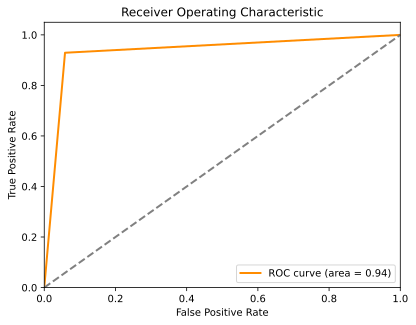

(array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]),
 array([3.69379044e-01, 9.89739895e-01, 2.98049778e-01, 3.28568146e-02,
        2.01368973e-01, 2.11651390e-03, 4.97782618e-01, 9.97488499e-01,
        1.34460675e-03, 9.97798979e-01, 9.97846484e-01, 3.11270240e-03,
        7.58187147e-03, 4.67076758e-03, 2.960

In [ ]:
rf_param_TfIdf_pca = {'max_depth': 1, 'max_features': 0.006835561166041448, 'n_estimators': 200}

train_and_predict(train_TfIdf_pca, 
                  train_y, 
                  test_TfIdf_pca, 
                  test_y, 
                  xgb.XGBClassifier(objective="binary:logistic", 
                                    eval_metric='logloss', 
                                    random_state=4487, 
                                    use_label_encoder=False,
                                    gamma= 0.4257366859173304, 
                                    learning_rate= 0.35526774997253563, 
                                    max_depth= 4, n_estimators= 734, 
                                    subsample= 0.6262634075987297),
                  None)

Here, we can define a more more complete function so that we can observe how different features perform with the same classifier and parameters.

In [ ]:
def train_and_predict_all_features(feature_sets, trainY, testY, clf, params, clf_name):
    
    if params is not None:
        clf = clf.set_params(**params)

    metrics_data = []
    plt.figure()
    testY = testY[::50]
    trainY = trainY[::50]

    for name, dataset in feature_sets.items():
        print("Training started. Feature set:",name)
        trainX = dataset[0][::50]
        testX = dataset[1][::50]


        # Training and Predicting
        clf.fit(trainX,trainY)

        print("Predicting started. Feature set:",name)
        predY = clf.predict(testX)
        predY_proba = clf.predict_proba(testX)

        # Calculate metrics data
        accuracy = accuracy_score(testY, predY)
        auc = roc_auc_score(testY, predY)
        f1 = f1_score(testY, predY)
        precision = precision_score(testY, predY)

        tn, fp, fn, tp = confusion_matrix(testY, predY).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        metrics_data.append([name, accuracy, auc, f1, precision, sensitivity, specificity])

        # Show metrics data
        print(f"Result for feature set: {name}")
        print("    Accuracy: ", accuracy)
        print("    AUC: ", auc)
        print("    F1 Score: ", f1)
        print("    Precision: ", precision)
        print("    Sensitivity: ", sensitivity)
        print("    Specificity: ", specificity)

        # Draw ROC Curve
        fpr, tpr, _ = roc_curve(testY, predY)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ['+clf_name+']')
    plt.legend(loc="lower right")
    plt.show()

    # Create a DataFrame to store the metrics data
    df = pd.DataFrame(metrics_data, columns=['name', 'accuracy', 'auc', 'f1', 'precision', 'sensitivity', 'specificity'])

    # Plot the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    metrics = df.columns[1:]  # Exclude the 'name' column
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    ax.set_thetagrids(np.degrees(angles), metrics, fontsize = 14)
    angles += angles[:1]  # To make the plot circular

    for i, row in df.iterrows():
        values = row[metrics].values.flatten().tolist()
        values += values[:1]  # To make the plot circular
        ax.plot(angles, values, label=row['name'], lw=1.75)

    ax.set_title('Comparison of metrics [' + clf_name + ']', size=16)
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, -0.1), prop={'size': 13})
    plt.show()
    return None

We currently have 5 methods for feature representation:

In [ ]:
feature_sets = {
    'TfIdf' : [train_TfIdf,test_TfIdf],
    'TfIdf_pca' : [train_TfIdf_pca,test_TfIdf_pca],
    'ngram': [train_ngram, test_ngram],
    'ngram_pca': [train_ngram_pca, test_ngram_pca],
    'w2v': [train_w2v, test_w2v]
}

First, we run Bernoullli Naive Bayes to see how it performs. To make it easier to save time, we sampled our runs and only ran one-tenth of the data. For the Kaggle submission we ran the full data.

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.9406392694063926
    AUC:  0.9875
    F1 Score:  0.931216931216931
    Precision:  0.9777777777777777
    Sensitivity:  0.8888888888888888
    Specificity:  0.9833333333333333
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.7899543378995434
    AUC:  0.876936026936027
    F1 Score:  0.7526881720430108
    Precision:  0.8045977011494253
    Sensitivity:  0.7070707070707071
    Specificity:  0.8583333333333333
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.9406392694063926
    AUC:  0.9875
    F1 Score:  0.931216931216931
    Precision:  0.9777777777777777
    Sensitivity:  0.8888888888888888
    Specificity:  0.9833333333333333
Training started. Feature set: ngram_pca
Predicting started. Feature set: ngram

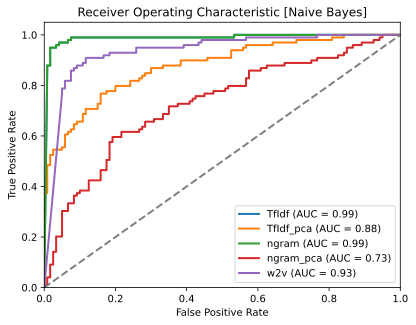

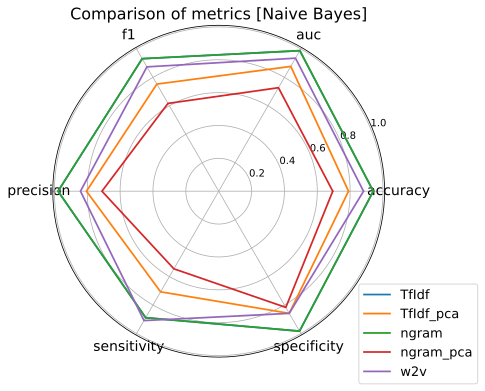

In [ ]:
# Bernoulli NB
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               naive_bayes.BernoulliNB(alpha=1e-10), 
                               None,
                               "Naive Bayes")

We can see that different feature representations have a significant impact on Bernoulli Naive Bayes. This may be because the performance of Naive Bayes is affected by the assumption of feature independence and also by feature sparsity.

In addition, the orange and red lines perform the worst, which may be due to the fact that PCA downscaling loses a lot of data.

Next, see how the random forest behaves.

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.9269406392694064
    AUC:  0.9805555555555555
    F1 Score:  0.9139784946236559
    Precision:  0.9770114942528736
    Sensitivity:  0.8585858585858586
    Specificity:  0.9833333333333333
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.9634703196347032
    AUC:  0.9905723905723907
    F1 Score:  0.9587628865979383
    Precision:  0.9789473684210527
    Sensitivity:  0.9393939393939394
    Specificity:  0.9833333333333333
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.9223744292237442
    AUC:  0.9771043771043771
    F1 Score:  0.9100529100529101
    Precision:  0.9555555555555556
    Sensitivity:  0.8686868686868687
    Specificity:  0.9666666666666667
Training started. Feature set: ngram_pca
Predicting 

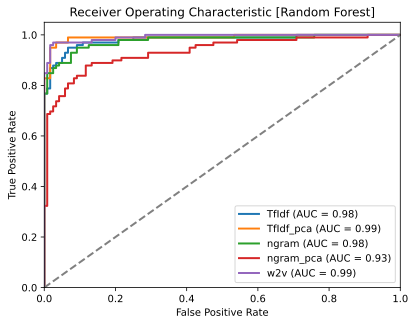

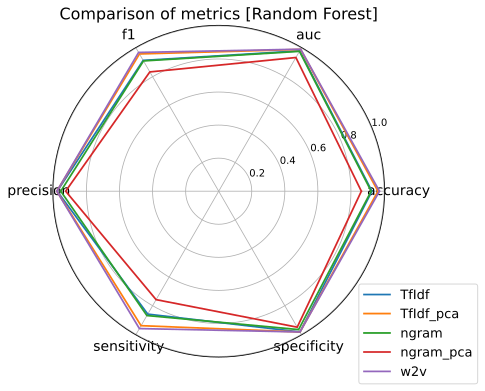

In [ ]:
# Random Forest
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               ensemble.RandomForestClassifier(random_state=4487), 
                               {'max_depth': 8, 'max_features': 0.14000883833708455, 'n_estimators': 1000},
                               "Random Forest")

Here, the gap between the performance of the different features is not as large as in Naive Bayes, but it can still be seen that the two features that have been through dimentionality reduction by PCA perform worse.

What about other classifiers?

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.9452054794520548
    AUC:  0.9756734006734008
    F1 Score:  0.9381443298969072
    Precision:  0.9578947368421052
    Sensitivity:  0.9191919191919192
    Specificity:  0.9666666666666667
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.9360730593607306
    AUC:  0.982996632996633
    F1 Score:  0.9278350515463918
    Precision:  0.9473684210526315
    Sensitivity:  0.9090909090909091
    Specificity:  0.9583333333333334
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.9360730593607306
    AUC:  0.978956228956229
    F1 Score:  0.9270833333333334
    Precision:  0.956989247311828
    Sensitivity:  0.898989898989899
    Specificity:  0.9666666666666667
Training started. Feature set: ngram_pca
Predicting star

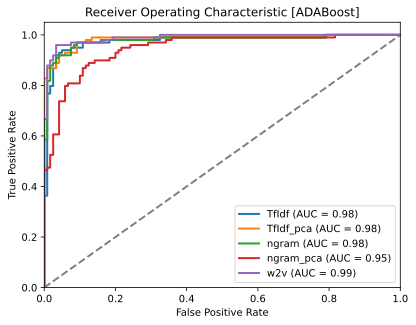

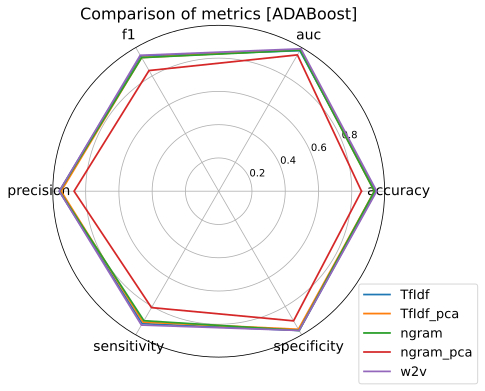

In [ ]:
# Ada Boost
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               ensemble.AdaBoostClassifier(random_state=4487), 
                               {'learning_rate': 0.03162277660168379, 'n_estimators': 500},
                               "ADABoost")

For AdaBoost Classifier, the NGram feature representation after PCA dimensionality reduction is very poor, and all other performances are close. This may be because for Adaboost Classifier, the NGram after PCA dimensionality reduction loses many important features.

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.9360730593607306
    AUC:  0.9757575757575757
    F1 Score:  0.9278350515463918
    Precision:  0.9473684210526315
    Sensitivity:  0.9090909090909091
    Specificity:  0.9583333333333334
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.9360730593607306
    AUC:  0.9854377104377104
    F1 Score:  0.9292929292929293
    Precision:  0.9292929292929293
    Sensitivity:  0.9292929292929293
    Specificity:  0.9416666666666667
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.9406392694063926
    AUC:  0.9826599326599327
    F1 Score:  0.9326424870466321
    Precision:  0.9574468085106383
    Sensitivity:  0.9090909090909091
    Specificity:  0.9666666666666667
Training started. Feature set: ngram_pca
Predicting 

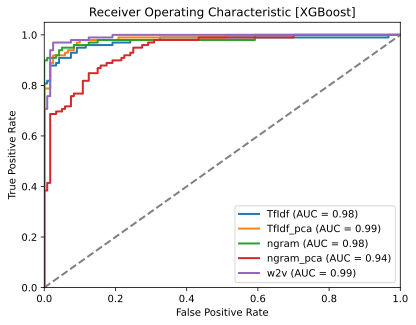

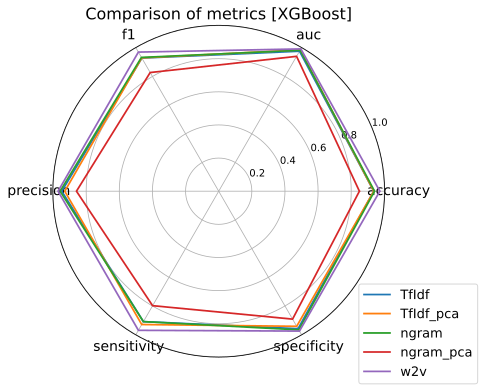

In [ ]:
# XGBoost
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', random_state=4487, use_label_encoder=False), 
                               {'gamma': 0.4257366859173304, 'learning_rate': 0.35526774997253563, 'max_depth': 4, 'n_estimators': 734, 'subsample': 0.6262634075987297},
                               "XGBoost")

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.9269406392694064
    AUC:  0.9731481481481481
    F1 Score:  0.9175257731958762
    Precision:  0.9368421052631579
    Sensitivity:  0.898989898989899
    Specificity:  0.95
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.9360730593607306
    AUC:  0.9728114478114479
    F1 Score:  0.9285714285714285
    Precision:  0.9381443298969072
    Sensitivity:  0.9191919191919192
    Specificity:  0.95
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.9269406392694064
    AUC:  0.9687710437710438
    F1 Score:  0.9166666666666667
    Precision:  0.946236559139785
    Sensitivity:  0.8888888888888888
    Specificity:  0.9583333333333334
Training started. Feature set: ngram_pca
Predicting started. Feature set: ngram_pc

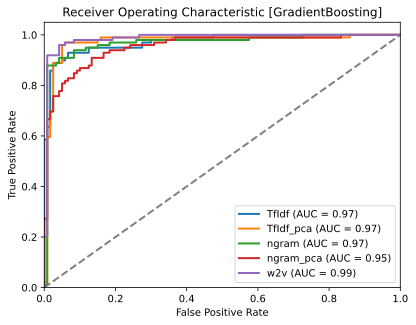

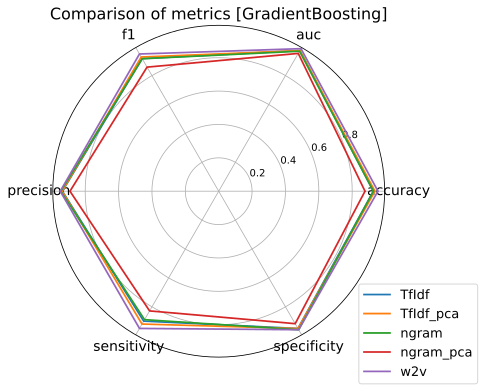

In [ ]:
# Gradient Boosting
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               ensemble.GradientBoostingClassifier(), 
                               {'n_estimators': 100, 'learning_rate': 1.0},
                               "GradientBoosting")

For the XGBoost Classifier and the Gradient Boosting Classifier, the same thing happed again. We suspect the reason may be similar to the previous one.

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.7625570776255708
    AUC:  0.8239478114478115
    F1 Score:  0.6623376623376623
    Precision:  0.9272727272727272
    Sensitivity:  0.5151515151515151
    Specificity:  0.9666666666666667
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.7899543378995434
    AUC:  0.8544612794612795
    F1 Score:  0.7088607594936709
    Precision:  0.9491525423728814
    Sensitivity:  0.5656565656565656
    Specificity:  0.975
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.8447488584474886
    AUC:  0.9065235690235691
    F1 Score:  0.8411214953271028
    Precision:  0.782608695652174
    Sensitivity:  0.9090909090909091
    Specificity:  0.7916666666666666
Training started. Feature set: ngram_pca
Predicting started. Featu

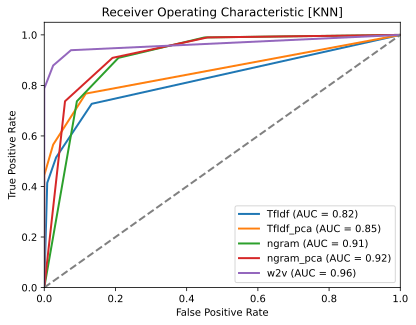

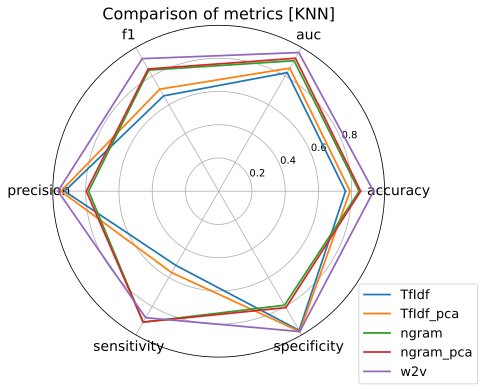

In [ ]:
# KNN
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               neighbors.KNeighborsClassifier(), 
                               {'n_neighbors': 3},
                               "KNN")

For KNN, we found something new. The TF-IDF feature representation is significantly worse in all the results, perhaps because the TF-IDF vectors are sparse, mostly 0, and all the data points can be far away, which makes it difficult for the KNN to find similar neighbors, leading to a degradation in KNN performance.


For some features, they have high Precision and low Sensitivity. This means that the model has a low error rate in predicting positive examples, however, the model did not manage to detect most of the true examples, i.e., the model may predict many samples that are actually positive as negative examples.

This suggests that the classifier may be overfitting and performing poorly in predicting positive examples, perhaps due to the imbalance in the distribution of the dataset.

Next is the performance of the SVM (different kernels).

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Result for feature set: TfIdf
    Accuracy:  0.547945205479452
    AUC:  0.9883838383838384
    F1 Score:  0.0
    Precision:  0.0
    Sensitivity:  0.0
    Specificity:  1.0
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Result for feature set: TfIdf_pca
    Accuracy:  0.547945205479452
    AUC:  0.9886363636363636
    F1 Score:  0.0
    Precision:  0.0
    Sensitivity:  0.0
    Specificity:  1.0
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.958904109589041
    AUC:  0.98493265993266
    F1 Score:  0.9547738693467336
    Precision:  0.95
    Sensitivity:  0.9595959595959596
    Specificity:  0.9583333333333334
Training started. Feature set: ngram_pca
Predicting started. Feature set: ngram_pca
Result for feature set: ngram_pca
    Accuracy:  0.958904109589041
    AUC:  0.9844276094276095
    F1 Score:  0.9547738693467336
    Precision:  0.95
    Sensitivity:  0.9595959595959596
    Specificity:  0.9583333333333334
Training started. Feature set: w2v
Predicting started. Feature set: w2v
Result for feature set: w2v
    Accuracy:  0.9634703196347032
    AUC:  0.9899831649831651
    F1 Score:  0.9587628865979383
    Precision:  0.97

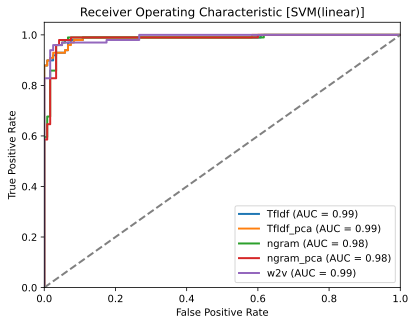

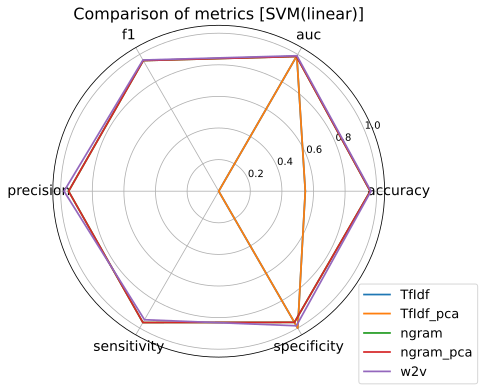

In [ ]:
# SVM(linear)
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               svm.SVC(), 
                               {'C': 0.01, 'kernel':'linear','probability':True},
                               "SVM(linear)")

The Tf-IDF(PCA) representation in SVM (linear kernel) behaves strangely, with precision f1 sensitivity being 0 and accuracy being 0.55. This situation could mean that the model predicts all samples to be 0, and does not predict any 1's. Thus, there are no true positives, resulting in the Precision, Sensitivity and F1 Score to be 0.

Training started. Feature set: TfIdf


Predicting started. Feature set: TfIdf


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Result for feature set: TfIdf
    Accuracy:  0.547945205479452
    AUC:  0.9884680134680135
    F1 Score:  0.0
    Precision:  0.0
    Sensitivity:  0.0
    Specificity:  1.0
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Result for feature set: TfIdf_pca
    Accuracy:  0.547945205479452
    AUC:  0.9882154882154882
    F1 Score:  0.0
    Precision:  0.0
    Sensitivity:  0.0
    Specificity:  1.0
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.9634703196347032
    AUC:  0.986026936026936
    F1 Score:  0.9595959595959596
    Precision:  0.9595959595959596
    Sensitivity:  0.9595959595959596
    Specificity:  0.9666666666666667
Training started. Feature set: ngram_pca
Predicting started. Feature set: ngram_pca
Result for feature set: ngram_pca
    Accuracy:  0.958904109589041
    AUC:  0.9854797979797979
    F1 Score:  0.9547738693467336
    Precision:  0.95
    Sensitivity:  0.9595959595959596
    Specificity:  0.9583333333333334
Training started. Feature set: w2v
Predicting started. Feature set: w2v
Result for feature set: w2v
    Accuracy:  0.9452054794520548
    AUC:  0.9927609427609427
    F1 Score:  0.9381443298969072
    

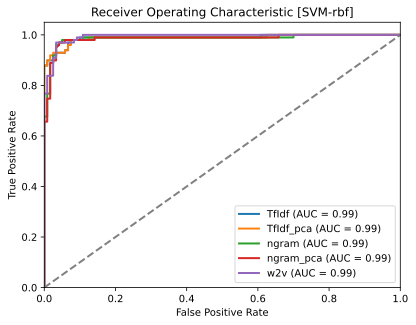

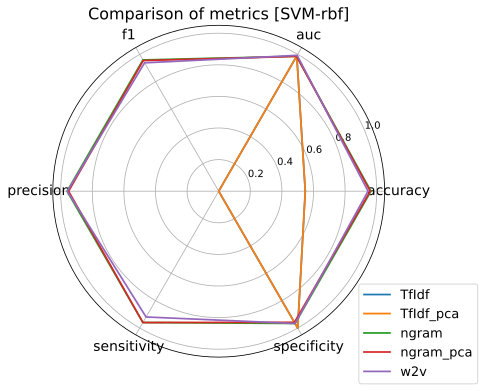

In [ ]:
# SVM-rbf
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               svm.SVC(), 
                               {'C': 1000.0, 'gamma': 0.0001, 'kernel':'rbf','probability':True},
                               "SVM-rbf")

The same situation happened again for SVMs with RBF kernels.

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.9680365296803652
    AUC:  0.9917508417508417
    F1 Score:  0.9633507853403142
    Precision:  1.0
    Sensitivity:  0.9292929292929293
    Specificity:  1.0
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.863013698630137
    AUC:  0.9877104377104376
    F1 Score:  0.8235294117647058
    Precision:  0.9859154929577465
    Sensitivity:  0.7070707070707071
    Specificity:  0.9916666666666667
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.954337899543379
    AUC:  0.9745791245791245
    F1 Score:  0.9494949494949495
    Precision:  0.9494949494949495
    Sensitivity:  0.9494949494949495
    Specificity:  0.9583333333333334
Training started. Feature set: ngram_pca
Predicting started. Feature set: ngram_pca


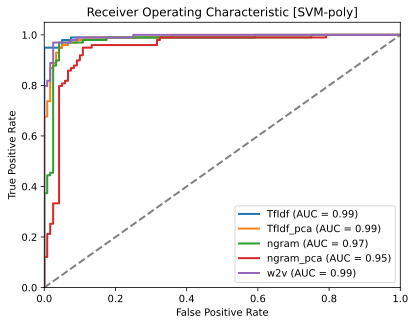

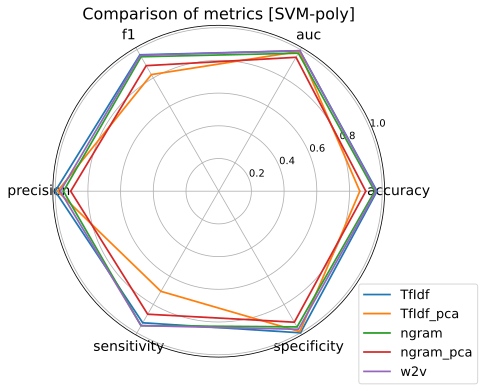

In [ ]:
# SVM-poly
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               svm.SVC(), 
                               {'C': 3.1622776601683795, 'degree': 2, 'kernel':'poly','probability':True},
                               "SVM-poly")

For the Poly kernel's SVM, this situation disappears. Maybe my feature representation has higher order polynomial relations that are more easily captured by the Polynomial kernel, better handling of complex decision boundaries and more flexible decision making.

In summary, according to these results, feature representations that have undergone PCA dimensionality reduction are missing some data. This leads to poorer performance of the results. There are some cases of low sensitivity, which may be due to the unbalanced input of the original data.

While the performances here all look pretty good and they all have high AUCs, the actual AUCs are actually between 0.77-0.80 in the Kaggle test, which is not a great result. We think this may be because of the overfitting that occurred. In addition, our dataset is not evenly distributed and there are some differences between the dataset used for training and testing and the actual dataset used for testing .

Since the Kaggle competition does not give an official dataset, the dataset we collected ourselves from a third party may not be good enough, which may explain why our results are not that good.

### Voting Classifier

Since we already have so many tuned parameterized classifiers, we might as well try a voting classifier. In this way, we can combine multiple models and balance the strengths and weaknesses of each to improve overall predictive performance.

Here, we have mainly used soft voting because we need the final output to be a probability value rather than a binary label.

We start by integrating these classifiers and associated parameters. For the SVM, we selected Multinomial Kernel because other kernel SVMs occurred with ZERO true positives when using TF-IDF Representation.

In [ ]:
clf_rf = ensemble.RandomForestClassifier(random_state=4487,max_depth=8,max_features=0.14000883833708455,n_estimators=1000)

clf_ada = ensemble.AdaBoostClassifier(random_state=4487,learning_rate=0.03162277660168379, n_estimators=500)

clf_xbg = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', random_state=4487, use_label_encoder=False,gamma= 0.4257366859173304, learning_rate= 0.35526774997253563, max_depth= 4, n_estimators= 734, subsample= 0.6262634075987297)

clf_gb = ensemble.GradientBoostingClassifier(n_estimators= 100, learning_rate = 1.0)

clf_knn = neighbors.KNeighborsClassifier(n_neighbors= 3)

clf_svm_poly = svm.SVC(C= 3.1622776601683795, degree= 2, kernel='poly',probability=True)

clf_nb = naive_bayes.BernoulliNB(alpha = 0.1)

We started by trying just a few clfs.

In [ ]:
clf_list = [('xbg', clf_xbg), 
            ('knn', clf_knn), 
            ('svm_poly', clf_svm_poly)]

voting_clf = ensemble.VotingClassifier(estimators=clf_list, voting='soft')

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.958904109589041
    AUC:  0.9849326599326599
    F1 Score:  0.9533678756476683
    Precision:  0.9787234042553191
    Sensitivity:  0.9292929292929293
    Specificity:  0.9833333333333333
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.9406392694063926
    AUC:  0.9853535353535354
    F1 Score:  0.9297297297297298
    Precision:  1.0
    Sensitivity:  0.8686868686868687
    Specificity:  1.0
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.9680365296803652
    AUC:  0.9846801346801347
    F1 Score:  0.9637305699481866
    Precision:  0.9893617021276596
    Sensitivity:  0.9393939393939394
    Specificity:  0.9916666666666667
Training started. Feature set: ngram_pca
Predicting started. Feature set: ngram_pca

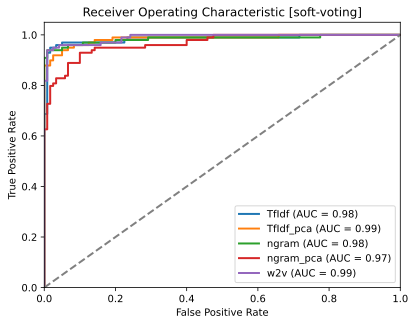

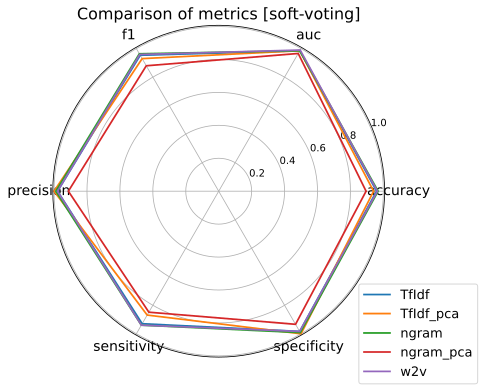

In [ ]:
train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               voting_clf, 
                               None,
                               "soft-voting")

Next, we tried adding all the clfs.

Training started. Feature set: TfIdf
Predicting started. Feature set: TfIdf
Result for feature set: TfIdf
    Accuracy:  0.9634703196347032
    AUC:  0.9846801346801347
    F1 Score:  0.9583333333333333
    Precision:  0.989247311827957
    Sensitivity:  0.9292929292929293
    Specificity:  0.9916666666666667
Training started. Feature set: TfIdf_pca
Predicting started. Feature set: TfIdf_pca
Result for feature set: TfIdf_pca
    Accuracy:  0.954337899543379
    AUC:  0.9881313131313133
    F1 Score:  0.9479166666666667
    Precision:  0.978494623655914
    Sensitivity:  0.9191919191919192
    Specificity:  0.9833333333333333
Training started. Feature set: ngram
Predicting started. Feature set: ngram
Result for feature set: ngram
    Accuracy:  0.958904109589041
    AUC:  0.9838383838383838
    F1 Score:  0.9533678756476683
    Precision:  0.9787234042553191
    Sensitivity:  0.9292929292929293
    Specificity:  0.9833333333333333
Training started. Feature set: ngram_pca
Predicting star

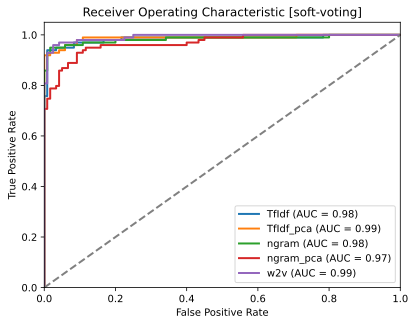

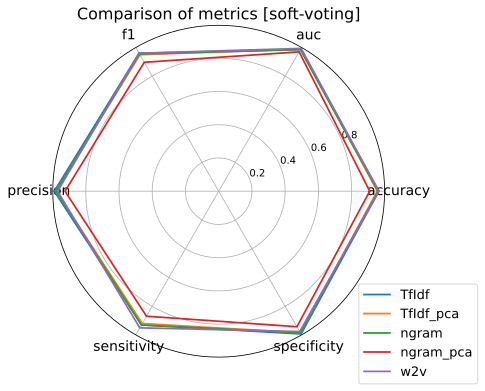

In [ ]:
clf_list = [('rf', clf_rf), 
            ('ada', clf_ada), 
            ('xbg', clf_xbg), 
            ('gb', clf_gb), 
            ('knn', clf_knn), 
            ('svm_poly', clf_svm_poly),
            ('nb',clf_nb)]

voting_clf = ensemble.VotingClassifier(estimators=clf_list, voting='soft')

train_and_predict_all_features(feature_sets, 
                               train_y, 
                               test_y, 
                               voting_clf, 
                               None,
                               "soft-voting")

The results here are significantly better, and the values of the reviews in Kaggle are also significantly better (for Word2Vec the AUC value for the Voting Classifier corresponds to 0.815, whereas for the Gradient Boosting Classifier it is only 0.779), but still very low, with a range of 0.78 - 0.81.

### Multilayer perceptron

We also tried using simple neural networks. Here we have implemented a simple MLP classifier. 

Here we need to import some necessary packages for deep learning first.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
import sys
print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')
from transformers import BertTokenizer, TFBertModel

Python: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0] Keras: 2.9.0 TF: 2.9.0


Here we used the function that plotted the training history from the previous tutorial.

In [ ]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    
    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')


Here we have modified the function that trains and calculates the metrics and plots the ROC curve to make it meets the training needs of the neural network.

Here, we further split the training dataset, from which we divide the validation set proportionally and validate it when training.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score
# reduce LR by a factor of 0.1, if no change in 5 epochs
lrschedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.1, patience=5, verbose=1)
callbacks_list = [lrschedule]

x_feature_sets = []
def train_and_predic_deep(trainX, trainY, testX, testY, clf, params=None):
    print(trainX.shape,testX.shape)
    print(trainY.shape,testY.shape)
    if type(trainX) != np.ndarray:
        trainX = trainX.numpy()
    if type(trainY) != np.ndarray:
        trainY = trainY.numpy()
    if type(testX) != np.ndarray:
        testX = testX.numpy()
    if type(testY) != np.ndarray:
        testY = testY.numpy()
    # trainX = list(trainX)
    # trainY = list(trainY)
    # testX = list(testX)
    # testY = list(testY)
    metrics_data = []
    # randomly split data into train and test set
    ( vtrainX, validX ) = model_selection.train_test_split(trainX, 
      train_size=0.9, test_size=0.1, random_state=4487)
    ( vtrainY, validY ) = model_selection.train_test_split(trainY,
      train_size=0.9, test_size=0.1, random_state=4487) 
    

    # print(vtrainX.shape,validX.shape)
    # print(vtrainY.shape,validY.shape)
    validsetX = (validX, validY)
    
    # clf = clf.set_params(**params)
    print("Training...")
    clf.summary()
    # train the model on the new data for a few epochs
    history = clf.fit(
                vtrainX, vtrainY,
                # datagen.flow(vtrainX, vtrainY, batch_size=bsize),  # data from generator
                steps_per_epoch=len(vtrainX)/bsize,    # should be number of batches per epoch
                epochs=40,
                callbacks = callbacks_list,
                validation_data=validsetX, 
                # validation_data=datagen.flow(validXim, validYb, batch_size=len(validXim)), 
                verbose=True)
    clf.save(clf.name)
    # new_model = tf.keras.models.load_model('path_to_my_model')
    print("Predicting...")
#     predY = clf.predict(testX)
#     predY_proba = clf.predict_proba(testX)
    
    plot_history(history)
    predYscore = clf.predict(testX, verbose=False)
    print(predYscore.shape)
    print(predYscore)
    predY = np.where(predYscore > 0.5, 1, 0)
    # predY = argmax(predYscore, axis=1)
    # acc = metrics.accuracy_score(testY, predY)
    # print("test accuracy:", acc)
    
    accuracy = accuracy_score(testY, predY)
    auc = roc_auc_score(testY, predYscore)
    f1 = f1_score(testY, predY)
    precision = precision_score(testY, predY)

    tn, fp, fn, tp = confusion_matrix(testY, predY).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    metrics_data.append([clf.name, accuracy, auc, f1, precision, sensitivity, specificity])
    
    print("    Accuracy: ", accuracy)
    print("    AUC: ", auc)
    print("    F1 Score: ", f1)
    print("    Precision: ", precision)
    print("    Sensitivity: ", sensitivity)
    print("    Specificity: ", specificity)

    # Draw ROC Curve
    fpr, tpr, _ = roc_curve(testY, predYscore)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
        # Create a DataFrame to store the metrics data
    df = pd.DataFrame(metrics_data, columns=['name', 'accuracy', 'auc', 'f1', 'precision', 'sensitivity', 'specificity'])

    # Plot the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    metrics = df.columns[1:]  # Exclude the 'name' column
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    ax.set_thetagrids(np.degrees(angles), metrics, fontsize = 14)
    angles += angles[:1]  # To make the plot circular

    for i, row in df.iterrows():
        values = row[metrics].values.flatten().tolist()
        values += values[:1]  # To make the plot circular
        ax.plot(angles, values, label=row['name'], lw=1.75)

    ax.set_title('Comparison of metrics [' + clf.name + ']', size=16)
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, -0.1), prop={'size': 13})
    plt.show()
    
    
    return predY, predYscore


Here we have implemented a simple neural network architecture which has 3 layers of Dense layers and in addition has two dropout layers to prevent overfitting.

In [ ]:
bsize = 128  # 16
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

nn = Sequential(name='w2v_MLP_255->64->1')
nn.add(Dense(256, activation='relu', input_shape=(500,)))
nn.add(Dropout(0.3))  # Add Dropout Layer to prevent overfitting
nn.add(Dense(units=64, activation='relu'))
nn.add(Dropout(rate=0.3, seed=11))
nn.add(Dense(units=1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 # compile and fit the network
nn.compile(loss=keras.losses.binary_crossentropy,
          optimizer=keras.optimizers.Adam(learning_rate=0.01),   
          metrics=['accuracy'])

2023-12-08 09:24:42.071487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 09:24:42.730065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 701 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6


(43752, 500) (10939, 500)
(43752,) (10939,)
Training...
Model: "w2v_MLP_255->64->1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               128256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 144,769
Trainable params: 144,769
Non-trainable params: 0
____________________________________________________

2023-12-08 09:24:44.031987: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


307/307 [==============================] - 2s 4ms/step - loss: 0.1205 - accuracy: 0.9578 - val_loss: 0.0887 - val_accuracy: 0.9723 - lr: 0.0100
Epoch 2/40
307/307 [==============================] - 1s 4ms/step - loss: 0.0816 - accuracy: 0.9711 - val_loss: 0.0633 - val_accuracy: 0.9790 - lr: 0.0100
Epoch 3/40
307/307 [==============================] - 1s 4ms/step - loss: 0.0736 - accuracy: 0.9759 - val_loss: 0.0586 - val_accuracy: 0.9810 - lr: 0.0100
Epoch 4/40
307/307 [==============================] - 1s 4ms/step - loss: 0.0671 - accuracy: 0.9785 - val_loss: 0.0573 - val_accuracy: 0.9799 - lr: 0.0100
Epoch 5/40
307/307 [==============================] - 1s 4ms/step - loss: 0.0632 - accuracy: 0.9793 - val_loss: 0.0618 - val_accuracy: 0.9808 - lr: 0.0100
Epoch 6/40
307/307 [==============================] - 1s 4ms/step - loss: 0.0595 - accuracy: 0.9797 - val_loss: 0.0485 - val_accuracy: 0.9842 - lr: 0.0100
Epoch 7/40
307/307 [==============================] - 1s 4ms/step - loss: 0.0612 

INFO:tensorflow:Assets written to: w2v_MLP_255->64->1/assets


Predicting...
(10939, 1)
[[4.7185884e-05]
 [1.0000000e+00]
 [1.0000000e+00]
 ...
 [1.4051248e-07]
 [1.0000000e+00]
 [9.9992609e-01]]
    Accuracy:  0.9872931712222324
    AUC:  0.9986511211396276
    F1 Score:  0.9859325979151907
    Precision:  0.9892363931762794
    Sensitivity:  0.9826507968529352
    Specificity:  0.991140086927449


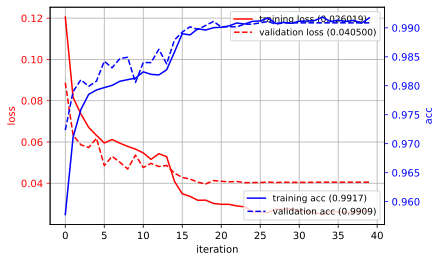

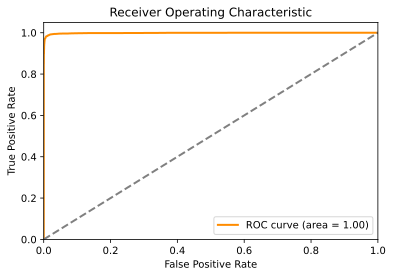

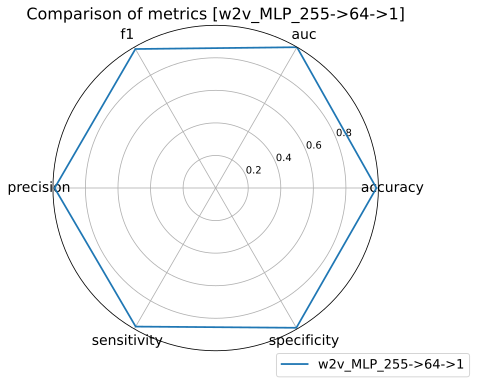

(array([[0],
        [1],
        [1],
        ...,
        [0],
        [1],
        [1]]),
 array([[4.7185884e-05],
        [1.0000000e+00],
        [1.0000000e+00],
        ...,
        [1.4051248e-07],
        [1.0000000e+00],
        [9.9992609e-01]], dtype=float32))

In [ ]:
train_and_predic_deep(train_w2v, 
                  train_y, 
                  test_w2v, 
                  test_y, 
                  nn)

According to our results, the MLP metrics are good on our dataset. However, after we submitted these codes to kaggle, the final AUC value was not less than 0.8, only 0.75. We still think that overfitting may have occurred in our model, even though we added Dropout layers to avoid overfitting. Using more as well as more balanced datasets might improve this.

## BERT

We noticed that a new language model called BERT[4] might has a better performance, therefore we also tried to implement a Bidirectional Encoder Representations from Transformers(BERT) model. According to the original paper, BERT "is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning left and right contexts in all layers". We can implement the BERT model by simply add a output layer.

We need to preload these with the trained model first.

In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

def extract_bert_features(texts, batch_size=128):
    all_features = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=64, return_tensors='tf')
        outputs = model(encoded_inputs, output_hidden_states=True)
        all_features.append(outputs.last_hidden_state)
    return tf.concat(all_features, axis=0)

def bert_function():
    train_bert_all2 = extract_bert_features(train_text_list[1::2])
    test_bert_all2 = extract_bert_features(test_text_list[1::2])

    train_bert2 = train_bert_all2[:, 0, :].numpy()
    test_bert2 = test_bert_all2[:, 0, :].numpy()

    np.save('train_bert_npy2.npy', train_bert2)
    np.save('test_bert_npy2.npy', test_bert2)

    final_using_train_bert_all = tf.concat([train_bert_all2, test_bert_all2], axis=0)
    np.save('final_using_train_bert_all2.npy', final_using_train_bert_all)

# bert_function()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# train_bert_npy = np.load('train_bert_npy.npy')
# test_bert_npy = np.load('test_bert_npy.npy')
# train_bert_npy = [train_bert_npy, train_bert2]
# train_bert_npy = tf.concat(train_bert_npy, axis=0)
# train_bert_npy.shape
# test_bert_npy = [test_bert_npy, test_bert2]
# test_bert_npy = tf.concat(test_bert_npy, axis=0)
# test_bert_npy.shape
# np.save('train_bert_npy_all.npy', train_bert_npy)
# np.save('test_bert_npy_all.npy', test_bert_npy)

We need to save these for later processing.

In [ ]:
train_bert_npy = np.load('train_bert_npy_all.npy')
test_bert_npy = np.load('test_bert_npy_all.npy')

train_y1 = train_y[::2]
train_y2 =train_y[1::2]
test_y1 = test_y[::2]
test_y2 = test_y[1::2]

train_y_changed = [train_y1, train_y2]
test_y_changed = [test_y1, test_y2]
train_y_changed = tf.concat(train_y_changed, axis=0).numpy()
test_y_changed = tf.concat(test_y_changed, axis=0).numpy()

We need to add an output layer to it to implement BERT. similar to the previous MLP, we set up a simple MLP with 3 layers of Dense Layers and add a Dropout Layer to prevent overfitting.

In [ ]:
bsize = 128  # 16
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

nn = Sequential(name='bert_MLP_512->128->1')
nn.add(Dense(512, activation='relu', input_shape=(768,)))
nn.add(Dropout(0.5))  # Add Dropout to Prevent Overfitting
nn.add(Dense(units=128, activation='relu'))
# nn.add(Dropout(rate=0.2))
# nn.add(Dense(units=32, activation='relu'))
# nn.add(Dropout(rate=0.2))
nn.add(Dense(units=1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 # compile and fit the network
nn.compile(loss=keras.losses.binary_crossentropy,
          optimizer=keras.optimizers.Adam(learning_rate=0.01),   
          metrics=['accuracy'])

(43752, 768) (10939, 768)
(43752,) (10939,)
Training...
Model: "bert_MLP_512->128->1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               393728    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 459,521
Trainable params: 459,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
307/307 [==============================] - 2s 4ms/step - loss: 0.2543 - accuracy: 0.9097 - val_loss: 0.15

INFO:tensorflow:Assets written to: bert_MLP_512->128->1/assets


Predicting...
(10939, 1)
[[1.4699188e-05]
 [1.0000000e+00]
 [2.4683118e-02]
 ...
 [9.9999976e-01]
 [2.2531148e-02]
 [9.9635774e-01]]
    Accuracy:  0.9692842124508639
    AUC:  0.9942254475078789
    F1 Score:  0.9659643435980552
    Precision:  0.9700915564598169
    Sensitivity:  0.9618721000605205
    Specificity:  0.9754262788365096


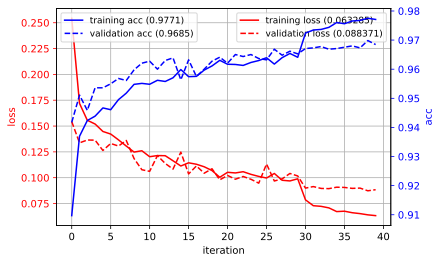

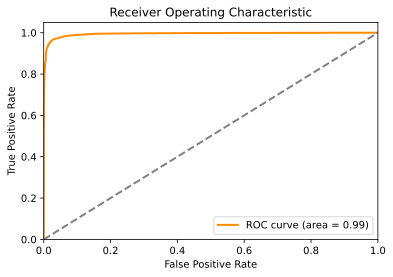

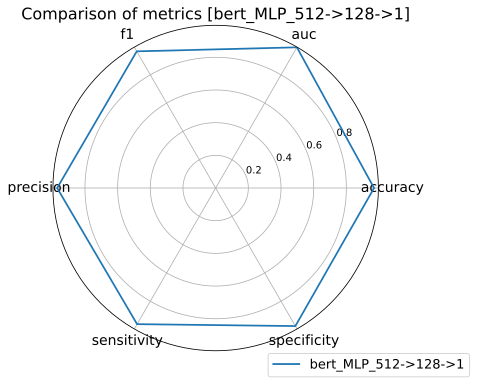

(array([[0],
        [1],
        [0],
        ...,
        [1],
        [0],
        [1]]),
 array([[1.4699188e-05],
        [1.0000000e+00],
        [2.4683118e-02],
        ...,
        [9.9999976e-01],
        [2.2531148e-02],
        [9.9635774e-01]], dtype=float32))

In [ ]:
train_and_predic_deep(train_bert_npy, 
                  train_y_changed, 
                  test_bert_npy, 
                  test_y_changed, 
                  nn)

For our attempt, the model with BERT performed well on our training set, but still performed mediocre in Kaggle. However, it is reassuring to see that this time the AUC value is slightly higher (0.79) on kaggle than the last time, though still not high. We think this model should still need further hyperparameter tuning and optimization in the

## Final Kaggle Submission

We have to admit that for the final Kaggle submission, our results were not good, with the highest value of 0.852, ranking in the bottom 50%. For this method we used a TF-IDF feature representation without dimensionality reduction, using the Bernoulli Naive Bayes classifier, where the $\alpha$ value is 1e-10. Even though we tried multiple feature representations and tried multiple machine learning methods, none of them ended up with AUC values as high as this one.

![Final Submission](imgs/final_kaggle.png)


We guess that on the one hand we did not handle the unbalanced data well, in addition to the fact that the processing of the features may not have characterized these texts very well. On the other hand, we think it might be a problem with the dataset itself.

Since the organizer did not give the dataset, we had to search for similar datasets from the Internet, which might be different from the actual test dataset. Our classifier which is prone to overfitting may not perform well with new datasets.

All in all, our AUC value is still above 0.85, and even though this value is not very high and belongs to the second half of the Kaggle competition, we still think that our classifier is effective to some extent.

## References
[1] Jules King, Perpetual Baffour, Scott Crossley, Ryan Holbrook, Maggie Demkin. (2023). LLM - Detect AI Generated Text. Kaggle. https://kaggle.com/competitions/llm-detect-ai-generated-text

[2] Luciano Batista.(2023). DAIGT - One Place, All Data. Kaggle. https://www.kaggle.com/datasets/dsluciano/daigt-one-place-all-data

\[3\] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv preprint arXiv:1301.3781.

[4]Jacon D., Ming-Wei C., Kenton L., Kristina T.(2018).BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. arXiv preprint arXiv:1810.04805.